# Hotel Reservation Cancellation Prediction - Advanced Analysis
    
## Project Overview
This notebook presents an advanced machine learning solution to predict hotel reservation cancellations.
We utilize synthetic data mimicking real-world hotel booking scenarios to build robust classification models.

## Methodology
1. Data Loading & Generation
2. Exploratory Data Analysis (EDA)
3. Data Preprocessing (Scaling, Encoding)
4. Model Training (Logistic Regression, Random Forest, XGBoost)
5. Evaluation & SHAP Explanation


In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score
import xgboost as xgb
import shap

# Set plotting style
sns.set(style="whitegrid")

# Load Data
data_path = '../data/hotel_reservations.csv'
df = pd.read_csv(data_path)
print(f"Data Loaded: {df.shape}")
df.head()


Data Loaded: (36275, 19)


,Booking_ID,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
0,INN00001,2,0,1,2,Meal Plan 1,0,Room_Type 1,224,2017,10,2,Offline,0,0,0,65.00,0,Not_Canceled
1,INN00002,2,0,2,3,Not Selected,0,Room_Type 1,5,2018,11,6,Online,0,0,0,106.68,1,Not_Canceled
2,INN00003,1,0,2,1,Meal Plan 1,0,Room_Type 1,1,2018,2,28,Online,0,0,0,60.00,0,Canceled
3,INN00004,2,0,0,2,Meal Plan 1,0,Room_Type 1,211,2018,5,20,Online,0,0,0,100.00,0,Canceled
4,INN00005,2,0,1,1,Not Selected,0,Room_Type 1,48,2018,4,11,Online,0,0,0,94.50,0,Canceled


## Exploratory Data Analysis
We analyze feature distributions and correlations to understand factors driving cancellations.


C:\Users\Nivedita\AppData\Local\Temp\ipykernel_64348\4202632552.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='booking_status', data=df, palette='viridis')


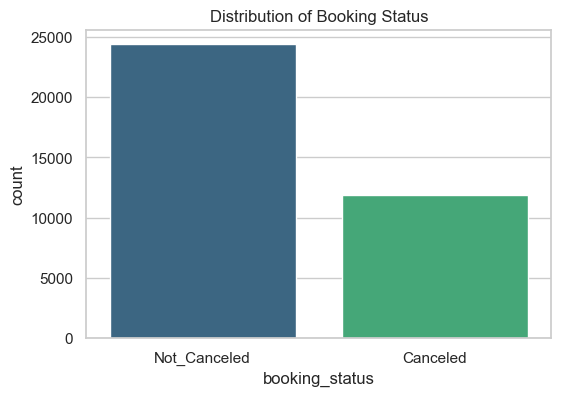

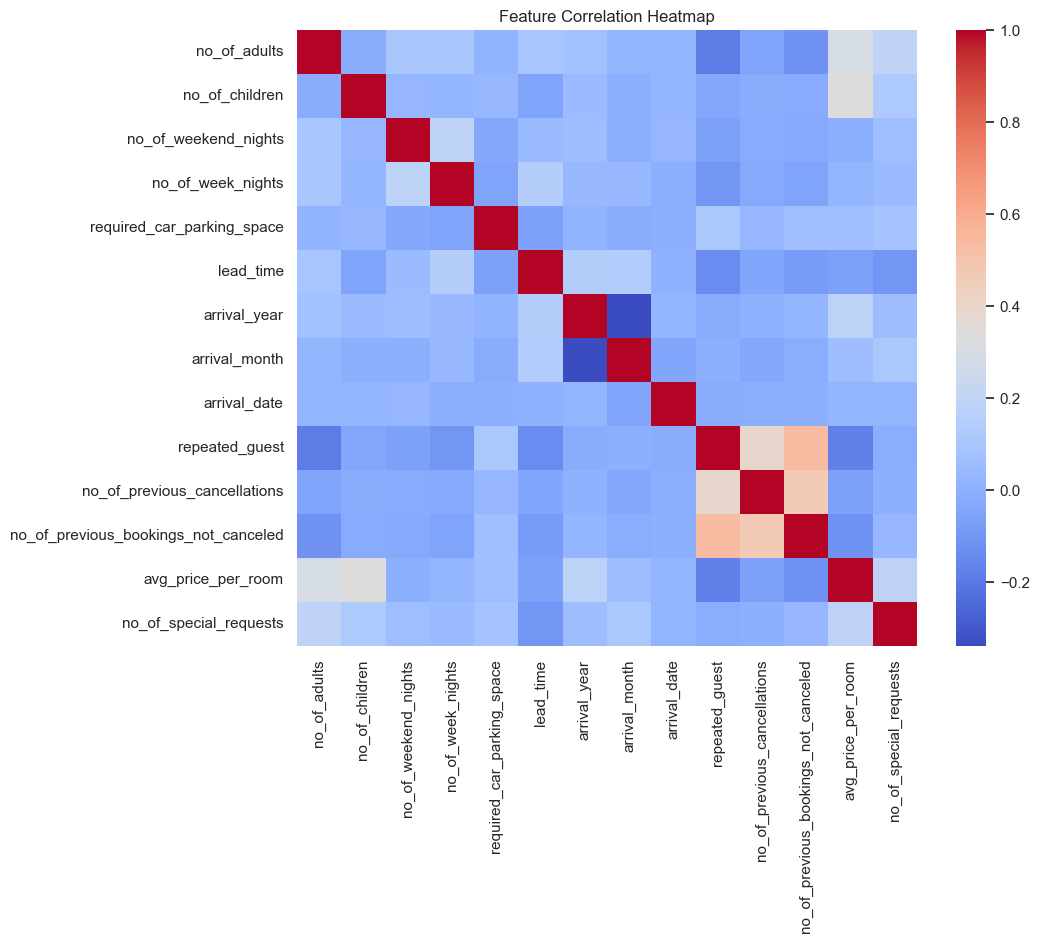

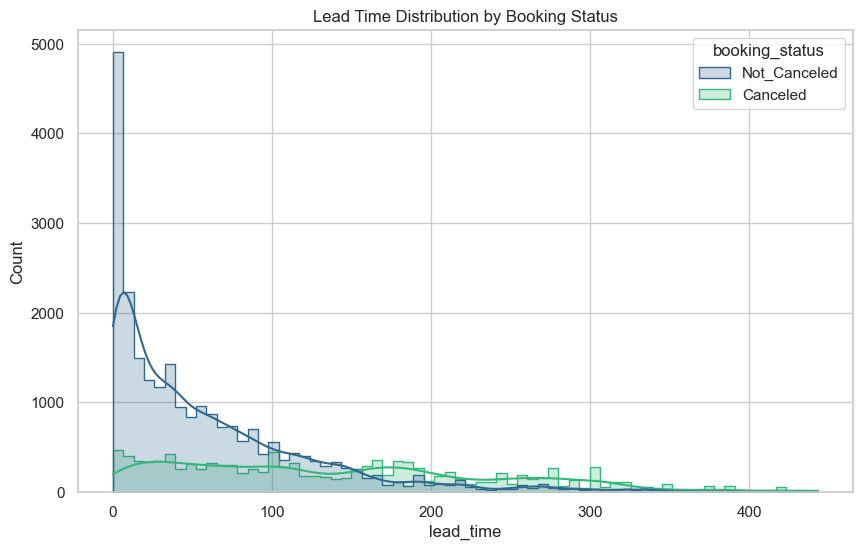

ValueError: Could not interpret value `market_segment` for `x`. An entry with this name does not appear in `data`.

<Figure size 1000x600 with 0 Axes>

In [12]:

# Target Distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='booking_status', data=df, palette='viridis')
plt.title('Distribution of Booking Status')
plt.show()

# Correlation Heatmap
plt.figure(figsize=(10, 8))
numeric_df = df.select_dtypes(include=['float64', 'int64'])
sns.heatmap(numeric_df.corr(), annot=False, cmap='coolwarm', fmt=".2f")
plt.title('Feature Correlation Heatmap')
plt.show()

# Lead Time vs Cancellation
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='lead_time', hue='booking_status', kde=True, element="step", palette='viridis')
plt.title('Lead Time Distribution by Booking Status')
plt.show()

# Market Segment Impact
plt.figure(figsize=(10, 6))
sns.countplot(x='market_segment', hue='booking_status', data=df, palette='viridis')
plt.title('Cancellation Rates by Market Segment')
plt.xticks(rotation=45)
plt.show()


## Model Development
We implement a pipeline with preprocessing (OneHotEncoding, StandardScaler) and train Logistic Regression, Random Forest, and XGBoost models.


In [15]:

# Feature Engineering & Preprocessing
df['total_nights'] = df['no_of_weekend_nights'] + df['no_of_week_nights']
df['total_guests'] = df['no_of_adults'] + df['no_of_children']

X = df.drop(['booking_status', 'Booking_ID', 'arrival_date', 'arrival_year'], axis=1)
y = df['booking_status'].apply(lambda x: 1 if x == 'Canceled' else 0)

# Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocessing Pipeline
cat_cols = ['meal_type', 'market_segment']
num_cols = [c for c in X.columns if c not in cat_cols]

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
    ])

print("Preprocessing Pipeline Defined")


Preprocessing Pipeline Defined


In [16]:

# Define Models
models = {
    'LogisticRegression': LogisticRegression(max_iter=1000),
    'RandomForest': RandomForestClassifier(n_estimators=100, random_state=42),
    'XGBoost': xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

trained_models = {}

for name, model in models.items():
    print(f"Training {name}...")
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('classifier', model)])
    pipeline.fit(X_train, y_train)
    
    # Evaluate
    y_pred = pipeline.predict(X_test)
    y_prob = pipeline.predict_proba(X_test)[:, 1]
    
    print(f"--- {name} Results ---")
    print(classification_report(y_test, y_pred))
    print(f"ROC-AUC: {roc_auc_score(y_test, y_prob):.4f}")
    print("-" * 30)
    
    trained_models[name] = pipeline


Training LogisticRegression...


ValueError: A given column is not a column of the dataframe

## Model Interpretability
Using SHAP (SHapley Additive exPlanations) to understand feature importance for the Random Forest model.


In [13]:

# SHAP Analysis on Random Forest
rf_pipeline = trained_models['RandomForest']
preprocessor = rf_pipeline.named_steps['preprocessor']
rf_model = rf_pipeline.named_steps['classifier']

# Transform X_test to get feature names
X_test_transformed = preprocessor.transform(X_test)
cat_encoder = preprocessor.named_transformers_['cat']
feature_names = num_cols + list(cat_encoder.get_feature_names_out(cat_cols))

# SHAP Explainer
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_test_transformed)

# Visualization
shap.summary_plot(shap_values[1], X_test_transformed, feature_names=feature_names)


NameError: name 'trained_models' is not defined